In [1]:
#Função de simulação de pesos de carteiras
pesos_carteira <- function(n_acoes, n_sim, short = F){
  pesos <- matrix(0,n_acoes,n_sim)
  if(isFALSE(short)){
    pesos <- apply(pesos,2,rexp,0.001)
  }else{
    pesos <- apply(pesos,2,rnorm)
    
  }
  pesos <- apply(pesos,2,function(x)x/sum(x))
  colsub <- apply(pesos,2,function(x)!any(x >= 1| x <= -1))
  pesos <- pesos[,colsub]
  return(pesos)
}

In [2]:
options(warn = -1, scipen = 999)
pacotes <- c("dplyr","tidyr","tidyquant")
for(i in pacotes){
    suppressPackageStartupMessages(library(i, character.only = T))
}

In [3]:
#Todas as ações do Ibovespa atualmente
acoes <- c("ABEV3.SA","AZUL4.SA","B3SA3.SA","BBDC3.SA",
           "BBDC4.SA","BBSE3.SA","BEEF3.SA","BPAC11.SA",
           "BRAP4.SA","BRDT3.SA","BRFS3.SA","BRKM5.SA",
           "BRML3.SA","BTOW3.SA","CCRO3.SA","CIEL3.SA",
           "CMIG4.SA","COGN3.SA","CPFE3.SA","CRFB3.SA",
           "CSAN3.SA","CVCB3.SA","CYRE3.SA","ECOR3.SA",
           "EGIE3.SA","ELET3.SA","ELET6.SA","EMBR3.SA",
           "ENBR3.SA","ENGI11.SA","EQTL3.SA","FLRY3.SA",
           "GGBR4.SA","GNDI3.SA","GOAU4.SA","GOLL4.SA",
           "HAPV3.SA","HGTX3.SA","HYPE3.SA","IGTA3.SA",
           "IRBR3.SA","ITSA4.SA","ITUB4.SA","JBSS3.SA",
           "KLBN11.SA","LAME4.SA","LREN3.SA","MGLU3.SA",
           "MRFG3.SA","MRVE3.SA","MULT3.SA","NTCO3.SA",
           "PCAR3.SA","PETR3.SA","PETR4.SA","QUAL3.SA",
           "RADL3.SA","RAIL3.SA","RENT3.SA","SANB11.SA",
           "SBSP3.SA","SULA11.SA","SUZB3.SA","TAEE11.SA",
           "TIMP3.SA","TOTS3.SA","UGPA3.SA","USIM5.SA",
           "VALE3.SA","VIVT4.SA","VVAR3.SA","WEGE3.SA"
          )

In [4]:
#Coletando os preços das ações e colocando em mesma escala
precos <- tq_get(acoes, from = Sys.Date()-365*4)
precos_mat <- precos %>%
  group_by(date, symbol) %>%
  summarise(close) %>%
  spread(key = symbol, value = close)
precos_mat[,1] <- NULL
precos_mat <- as.matrix(precos_mat)
for(i in 1:ncol(precos_mat)){
  precos_mat[,i] <- precos_mat[,i]/precos_mat[1,i]
}

`summarise()` regrouping output by 'date' (override with `.groups` argument)



In [5]:
first <- dplyr::first(precos$date)
first

[1] "2016-08-26"

In [6]:
#Pegando os dados do Ibovespa
ibov <- tq_get("^BVSP", from = first) %>%
  group_by(date, symbol) %>%
  summarise(close) %>%
  spread(key = symbol, value = close)
ibov <- ibov[,2] %>% as.matrix
ibov <- ibov/ibov[1]

`summarise()` regrouping output by 'date' (override with `.groups` argument)



In [46]:
#Parâmetros da simulação
n_sim <- 1000
n_acoes <- 5
pesos <- pesos_carteira(n_acoes = n_acoes, n_sim = n_sim, short = F)
acoes_s <- matrix(0, nrow = n_acoes, ncol = ncol(pesos))
for(i in 1:ncol(acoes_s)){
  acoes_s[,i] <- sample(1:length(acoes), n_acoes)
}

In [47]:
carteiras <- matrix(0,nrow = nrow(precos_mat), ncol = ncol(pesos))
#Número de simulações
ncol(carteiras)

[1] 1000

In [48]:
for(i in 1:nrow(carteiras)){
  for(j in 1:ncol(carteiras)){
    carteiras[i,j] <- sum(precos_mat[i,acoes_s[,j]]*pesos[,j])
  }
}

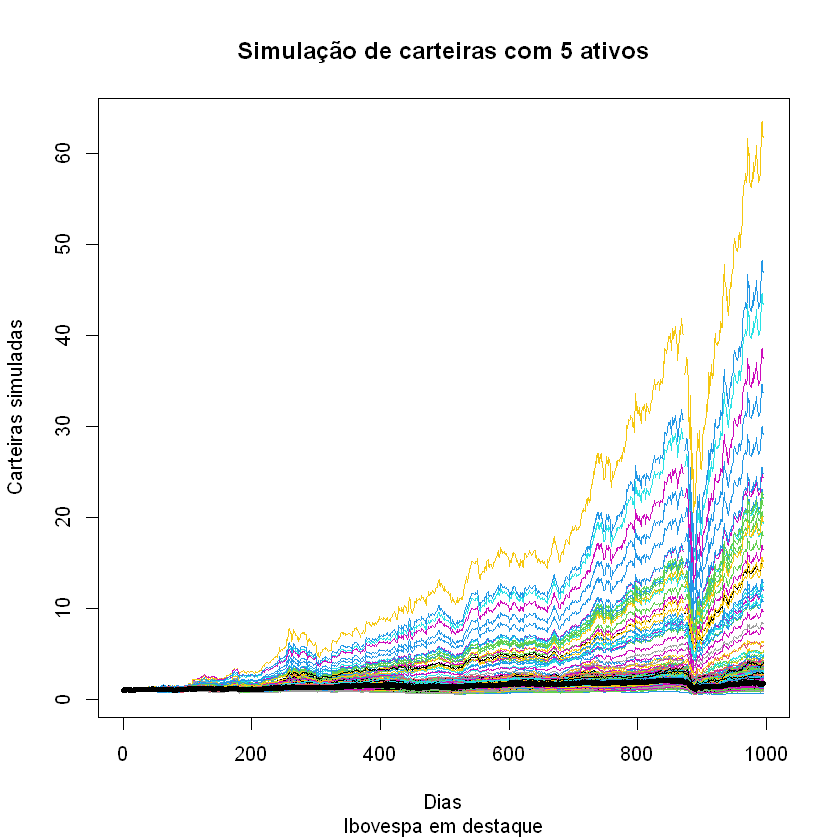

In [49]:
matplot(carteiras, type = "l", lty = 1, col = 1:n_sim, xlab = "Dias", ylab = "Carteiras simuladas",
       main = paste("Simulação de carteiras com",n_acoes,"ativos"), sub = "Ibovespa em destaque")
lines(ibov, lwd = 4)

In [50]:
carteiras_s <- na.fill(carteiras,0)
maior <- carteiras_s[nrow(carteiras_s),] == max(carteiras_s[nrow(carteiras_s),])

In [51]:
#Carteira de maior retorno
p <- round(pesos[,maior]*100,2)
a <- acoes_s[,maior]
a <- acoes[a]
names(p) <- a
print(p)

MRVE3.SA MGLU3.SA BRFS3.SA WEGE3.SA ELET6.SA 
    3.18    68.39    15.11     1.42    11.91 


In [52]:
#Dados da carteira
ret <- diff(carteiras[,maior])/carteiras[2:nrow(carteiras)-1,maior]
sd_c <- c(sd(ret, na.rm = T)*sqrt(252),carteiras_s[nrow(carteiras_s),maior]-1)
names(sd_c) <- c("Volatilidade anual do período","Retorno no Período")
print(sd_c)

Volatilidade anual do período            Retorno no Período 
                    0.5802945                    60.7450518 


In [53]:
sd_t <- matrix(0, nrow = 1, ncol = ncol(pesos))
sharpe <- matrix(0, nrow = 1, ncol = ncol(pesos))
for(i in 1:ncol(sd_t)){
  sd_t[i] <- sd((diff(carteiras[,i])/carteiras[1:nrow(carteiras),i]),
                na.rm = T)*sqrt(nrow(carteiras))
  sharpe[i] <- (carteiras_s[nrow(carteiras_s),i]-1)/sd_t[i]
}
sharpe_m <- sharpe == max(sharpe, na.rm = T)
for(i in 1:length(sharpe_m)){
  if(is.na(sharpe_m[i])){
    sharpe_m[i] <- F
  }
}

In [54]:
#Carteira com maior sharpe
r_m <- last(carteiras_s[,sharpe_m]-1)
sd_m <- sd_t[,sharpe_m]
s_m <- sharpe[sharpe_m]
p_m <- round(pesos[,sharpe_m]*100,2)
a_m <- acoes_s[,sharpe_m]
a_m <- acoes[a_m]
names(sd_m) <- "Desvio da carteira"
names(r_m) <- "Retorno da carteira"
names(s_m) <- "Sharpe da Carteira"
names(p_m) <- a_m
sd_m
r_m
s_m

Desvio da carteira 
          1.153086

Retorno da carteira 
           60.74505

Sharpe da Carteira 
          52.68041

In [55]:
#Pesos da carteira com maior sharpe
print(p_m)

MRVE3.SA MGLU3.SA BRFS3.SA WEGE3.SA ELET6.SA 
    3.18    68.39    15.11     1.42    11.91 


In [56]:
#% de carteiras que bateram o IBOVESPA no período
porc <- table(carteiras_s[nrow(carteiras_s),] >= ibov[nrow(ibov)], useNA = "no")
porc <- porc/sum(porc)
names(porc) <- c("Rendeu menos","Rendeu Mais")
porc

Rendeu menos  Rendeu Mais 
       0.698        0.302 

In [57]:
menor <- carteiras_s[nrow(carteiras_s),] == min(carteiras[nrow(carteiras_s),], na.rm = T)
#Carteira de menor retorno
p_mn <- round(pesos[,menor]*100,2)
a_mn <- acoes_s[,menor]
a_mn <- acoes[a_mn]
names(p_mn) <- a
print(p_mn)

MRVE3.SA MGLU3.SA BRFS3.SA WEGE3.SA ELET6.SA 
    8.93    55.60    12.50    10.42    12.55 


In [58]:
#Dados da carteira
ret_mn <- diff(carteiras[,menor])/carteiras[1:nrow(carteiras),menor]
sd_c_mn <- c(sd(ret_mn, na.rm = T)*sqrt(252),carteiras_s[nrow(carteiras_s),menor]-1)
names(sd_c_mn) <- c("Volatilidade anual do período","Retorno no Período")
print(sd_c_mn)

Volatilidade anual do período            Retorno no Período 
                    0.2656176                    -0.4074113 
